In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import rcParams


In [2]:
path = '/Users/busracagirici/Downloads/'
table_path = '/Users/busracagirici/Downloads/'
figure_path = '/Users/busracagirici/Downloads/'

adata = sc.read_h5ad(path+'GSE272840_ALO_viscRNAseq.h5ad')


In [3]:
filtered =adata[(adata.obs.high_quality=='True') & 
               #(adata.obs.cell_type.isin(['AT2-like cells'])) &
                (adata.obs.ID.isin(['24h_infected_DMSO', '24h_infected_RMC-113', '24h_uninfected_DMSO', '24h_uninfected_RMC-113']))
               ]
filtered

View of AnnData object with n_obs × n_vars = 19709 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [4]:
### Normalize RNA counts
filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered.copy()

In [5]:
### Supplementary Fig. 8a

filtered.obs['bystanders'] = 'low (1-3)'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high >3'

filtered.obs['Infection status'] = filtered.obs.ID.str.contains('uninfected').astype(str)
filtered.obs['Infection status'] = filtered.obs['Infection status'].map({'True': 'Uninfected', 'False': 'SARS-CoV-2'})

filtered.obs['Treatment'] = filtered.obs.ID.str.contains('DMSO').astype(str)
filtered.obs['Treatment'] = filtered.obs['Treatment'].map({'True': 'DMSO', 'False': 'RMC-113'})

pd.DataFrame(filtered.obs.groupby(['Infection status', 'Treatment', 'bystanders']).size()).reset_index().pivot(columns='bystanders', values=0, index=['Infection status', 'Treatment']).fillna(0)

bystanders                  high >3  low (1-3)    zero
Infection status Treatment                            
SARS-CoV-2       DMSO         421.0     2649.0  5571.0
                 RMC-113      115.0     1363.0  6388.0
Uninfected       DMSO           0.0        0.0  1369.0
                 RMC-113        0.0        0.0  1833.0

In [6]:
def plot_gene_expression(filtered, ct, gene):
    import matplotlib.pyplot as plt
    from statannotations.Annotator import Annotator
    from matplotlib import rcParams
    rcParams['font.size']=8
    
    
    adata_tmp = filtered[filtered.obs.cell_type == ct].copy()
    df = adata_tmp.obs[['ID', 'cell_type']]
    df[gene] = adata_tmp[:,gene].X.A
    df.index.name = 'cellID'
    df = df.reset_index()
    df['newID'] = [' '.join(x.split('_')[1:]) for x in df.ID]


    pairs = [
    ['uninfected RMC-113', 'uninfected DMSO'],
    ['infected RMC-113', 'infected DMSO'],
    ['infected DMSO', 'uninfected DMSO'],
#    ['infected RMC-113', 'uninfected DMSO'],
    ]
    order = ['uninfected DMSO', 
         'uninfected RMC-113', 
         'infected DMSO', 
         'infected RMC-113', 
        ]
    cmap = sns.color_palette('Set2', 4)
    hue_plot_params = {'data': df.dropna(),
                   'x' : 'newID', 
                   'y' : gene, 
                   'order': order,
                   'zorder' : 8,
                   'boxprops': {'edgecolor':'none'}, 
                   'medianprops' : {'color':'black', 'linewidth':0.5},
                   'capprops' : {'color':'none'},
                   'palette' : ['silver', 'whitesmoke', 'silver', 'whitesmoke',], 
                   'width' : 0.8, 
                   'showfliers': False}

    fig, ax = plt.subplots(figsize=[2.5, 3])
    sns.boxplot(ax=ax, **hue_plot_params).legend(bbox_to_anchor=(1, 1))

    empty_box=False
    if empty_box:
        for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor((0, 0, 0, 0))
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                ax.lines[j].set_color(color)

            
    sns.stripplot(data = df.dropna(), 
              x = 'newID', y = gene, order=order, zorder=10,
             palette=cmap,  s=2, ax=ax, edgecolor='black', linewidth=0.3, dodge=True).legend('')


    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.new_plot(ax, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH", 
                    text_format="full", verbose=False, show_test_name=False).apply_and_annotate()

    ax.legend(loc=(1.05, 0.5))
    ax.set_ylabel(f'{gene} (log2(CPM+1))', fontsize='medium')
    labels = [x.get_text() for x in ax.get_xticklabels()]
    ax.set_xticklabels([x.split()[1] for x in labels], rotation=45, fontsize='medium')
    ax.set_xlabel('Uninfected           Infected    ', fontsize='medium')
    ax.set_axisbelow(True)
    #ax.grid(True)


    #plt.savefig(f'{figure_path}{gene}_allpvals.svg')
    fig.tight_layout()
    #plt.savefig(f'{figure_path}{gene}_allpvals.png')
    plt.show()
    return(fig, ax)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


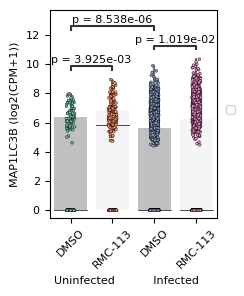

In [8]:
#### Fig 5m

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'MAP1LC3B')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


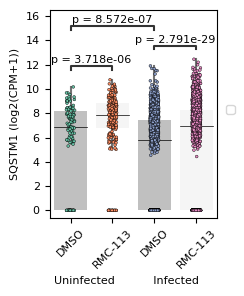

In [8]:
#### Fig 5n

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'SQSTM1')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


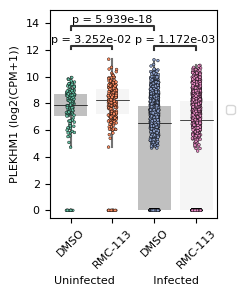

In [9]:
#### Fig 5o

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'PLEKHM1')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


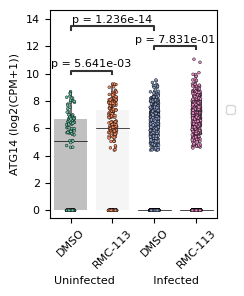

In [10]:
#### Supplementary Fig 8c

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'ATG14')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


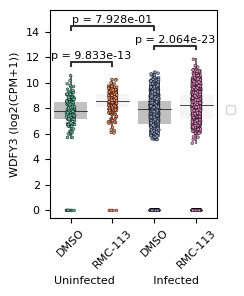

In [11]:
#### Supplementary Fig 8d

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'WDFY3')